#W207 Machine Learning Final Project #
###Forest Cover Type Prediction###
Amitava Das & Katherine Shelley

###Data Dictionary###

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, hstack

#plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#libraries for cleaning/feature selection
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold

#classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#metrics/cross-validation
from sklearn.cross_validation import cross_val_score

In [2]:
np.random.seed(0)

In [3]:
print os.getcwd()

/home/katherine/Berkeley/W207/W207_ML_Final


##Part 1: Data Collection and Baseline Estimation##
First we will download the data and split it into a training, development, and test sets.

###Load the data###
First let's load the data into a Pandas dataframe. The data has a lot of dummy binary features, which means there will be a lot of entries that are zero and we'll be adding more binary features to the data set. We will use a sparse representation in both Pandas and Numpy to save space and reduce computation time on the test set. Read more about Pandas sparse representation here: http://pandas.pydata.org/pandas-docs/stable/sparse.html and Numpy Column Sparse Row (CSR) matrices here: http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix

df_train type: <class 'pandas.core.frame.DataFrame'>
Training set shape (15120, 54)

df_test type: <class 'pandas.sparse.frame.SparseDataFrame'>
Test set shape (565892, 54)


(array([ 2160.,  2160.,     0.,  2160.,     0.,  2160.,  2160.,     0.,
         2160.,  2160.]),
 array([ 1. ,  1.6,  2.2,  2.8,  3.4,  4. ,  4.6,  5.2,  5.8,  6.4,  7. ]),
 <a list of 10 Patch objects>)

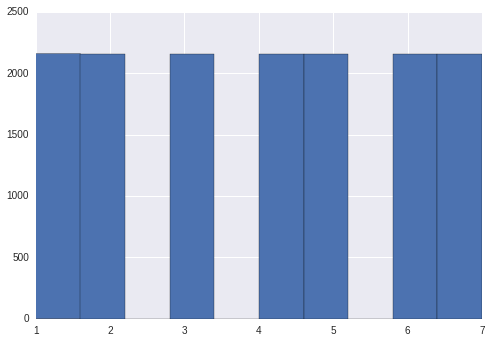

In [4]:
#read the training data into a pandas dataframe
data = os.path.join(os.getcwd(),'train.csv')
df_train = pd.read_csv(data)
#separate out the training labels, drop the Id column from the training dataset
df_train_labels = df_train['Cover_Type']
df_train = df_train.drop(['Id','Cover_Type'],1)

#read the test data into a pandas frame
data = os.path.join(os.getcwd(),'test.csv')
df_test = pd.read_csv(data).to_sparse()
#separate out the Id column, keep it for Kaggle submissions
test_ids = np.array(df_test['Id'])
df_test = df_test.drop(['Id'],1)


#You can see we have loaded the test data into a sparse dataframe
print 'df_train type: %s' % type(df_train)
print 'Training set shape %s' % str(df_train.shape)
print
print 'df_test type: %s' % type(df_test)
print 'Test set shape %s' % str(df_test.shape)

#let's take a look at the range of labels we have
plt.hist(df_train_labels.as_matrix())

###Baseline model###
We initially created a baseline model using the K-Nearest Neighbors classifier with n_neighbors set to 1. With this baseline we were able to obtain an accuracy of 71.06% against the test set.

In [5]:
#We will use this generic function for outputting Kaggle submission CSV files based
#on a classifier and training data we define
def print_out_kaggle_submission(clf,train_dat,train_lab,test_dat,ids):
    clf.fit(train_dat,train_lab)
    predicted = clf.predict(test_dat)
    outfile = zip(ids, predicted)
    np.savetxt("Submission.csv", outfile, fmt='%i', delimiter=',', newline='\n', header='Id,Cover_Type',comments='')
    print "Saved ", len(outfile),"records to Submission.csv"
    plt.hist(predicted)

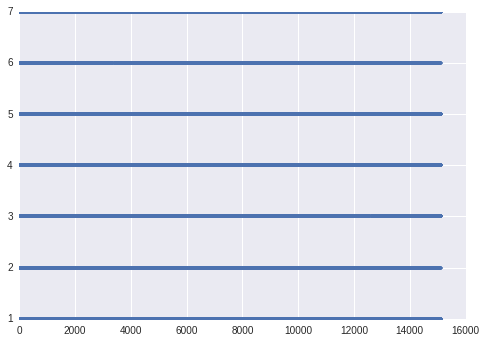

In [6]:
X = df_train.as_matrix()
Y = df_train_labels.as_matrix()
test_data = csr_matrix(df_test.as_matrix())

shuffle = np.random.permutation(np.arange(X.shape[0]))
X,Y = X[shuffle],Y[shuffle]

plt.plot(range(X.shape[0]),Y,".") #plot the occurence of each target to ensure we have a good random mix

Saved  565892 records to Submission.csv


(array([  44102.,       0.,   14869.,       0.,   65402.,       0.,
         431538.,       0.,       0.,    9981.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ]),
 <a list of 10 Patch objects>)

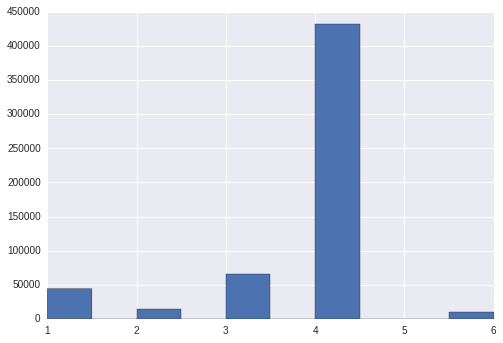

In [10]:
knn = KNeighborsClassifier(n_neighbors=1)
print_out_kaggle_submission(knn,X,Y,test_data.todense(),test_ids)

##Part 2: Exploring Different Models##
Next we will use Grid Search to analyze various models to see if we get improvement simply by switching from Nearest Neighbors.

In [12]:
X = df_train.as_matrix()
Y = np.array(df_train_labels) 

shuffle = np.random.permutation(np.arange(X.shape[0]))
X,Y = X[shuffle],Y[shuffle]

# Set some variables to hold dev and training data;
N = X.shape[0]
dev_data, dev_labels = X[2*N/3:], Y[2*N/3:]
train_data, train_labels = X[:2*N/3], Y[:2*N/3]

print "Training data: %s" % str(train_data.shape)
print "Development data: %s" % str(dev_data.shape)

Training data: (10080, 54)
Development data: (5040, 54)


###Logistic Regression###
Gaussian Mixture Models did not give us very good accuracy. Let's see if we can do better with Logistic Regression. Logistic Regression is a popular choice for classification because it scales well to large datasets and because of it's probabalistic interpretation.

In [5]:
lm = LogisticRegression(C=0.1) #initialize a logistic regression model
lm.fit(train_data,train_labels)
print '%s Accuracy using C = 0.1' % (lm.score(dev_data,dev_labels)*100)

67.0634920635 Accuracy using C = 0.1


###Random Forests###
Now Let's test a Random Forest with a large number of trees. Decision trees and random forests are a good tool because they generally build models that can be explicitly understood and explained, and they create non-linear decision boundaries. 

In [5]:
rf = RandomForestClassifier(n_estimators=25)
rf.fit(train_data,train_labels)
print 'Random Forest gives %s percent Accuracy using 25 trees' % (rf.score(dev_data,dev_labels)*100)

Random Forest gives 84.9801587302 percent Accuracy using 25 trees


Random forests have given by far the best accuracy that we have seen. Let's now evaluate this model.

##Part 3: Evaluating Our Model##
Next we will analyze the accuracy of our chosen model and explore feature engineering and dimensionality reduction to try to improve the accuracy of our Random Forest classifier.

###Bias/Variance Analysis###
A **high bias** model is one that is not affected strongly by changes to the training data; in other words the error rate between the training and development sets are similar, but shows a high amount of error against the test set. Namely it is a model that is **underfit**. A **high variance** model is one that is sensitive to changes in the training data and shows little to no error, however returns a high amount of error against the development and test sets; namely, an **overfit** model. 

Underfit and overfit models should be dealt with in very different ways when it comes to feature engineering, so before we can determine the steps we should take to improve our model's accuracy we need to understand if the baseline Random Forest is displaying high bias or high variance. To do this, let's run the model with various amounts of estimators and compare the error rate of the model on the training set versus our development set.

In [13]:
#Let's define a simple error rate function; concretely, the average percentage of predictions that are wrong.
def error_rate(clf,X,y):
    return 1.0/(X.shape[0])*np.sum(np.where(y<>clf.predict(X),np.ones(X.shape[0]),np.zeros(X.shape[0])))

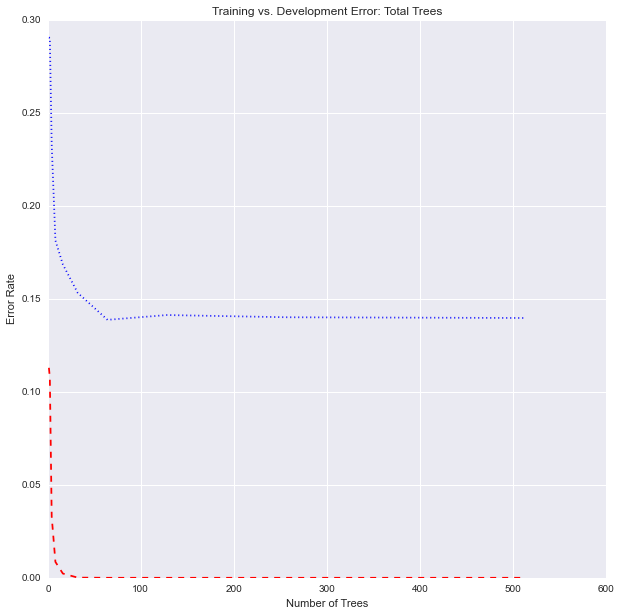

In [14]:
#iterate through several sizes of forest classifiers, 
#and plot the error rate of the training prediction vs. 
#the development prediction.
trees=[2**i for i in range(10)]
train_acc = []
dev_acc = []
for tree in trees:
    rf = RandomForestClassifier(n_estimators=tree)
    rf.fit(train_data,train_labels)
    train_acc.append(error_rate(rf,train_data,train_labels))
    dev_acc.append(error_rate(rf,dev_data,dev_labels))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(trees,train_acc,'--',c='r')
ax.plot(trees,dev_acc,':',c='b')
ax.set_ylabel("Error Rate")
ax.set_xlabel("Number of Trees")
ax.set_title("Training vs. Development Error: Total Trees")


The large gap in the error rate between the development set and the training set, along with the fact that the error rate on the training set essentially drops to 0 as the number of trees increases above 100 tells us that our model as it stands now is high variance and is overfitted. It turns out that trimming the number of features, and engineering new, more generic features does little to help the fit of the random forest model. This is due to the very small training data size versus the test data.

Next let's look at the effect of reducing the size of each tree. We will again compare the error rates of the training set against the development set, but this time we'll run for various sizes of each tree.

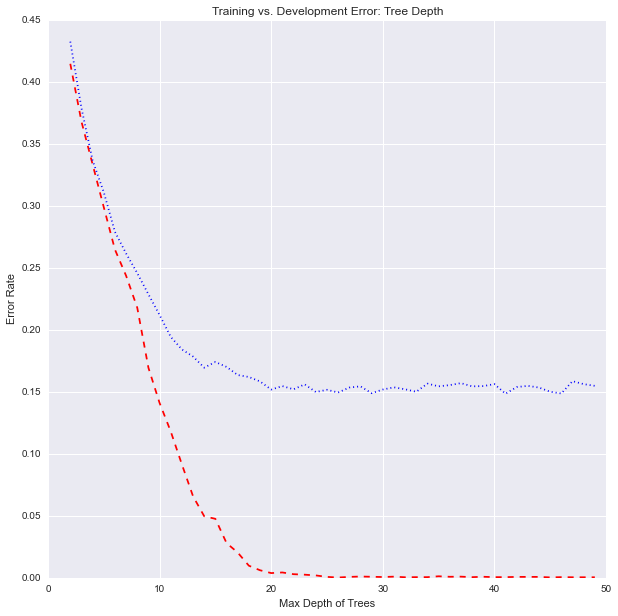

In [15]:
#iterate through several numbers of levels, 
#and plot the error rate of the training prediction vs. 
#the development prediction.
levels = range(2,50,1)
train_acc = []
dev_acc = []
for level in levels:
    rf = RandomForestClassifier(n_estimators=25,max_depth=level)
    rf.fit(train_data,train_labels)
    train_acc.append(error_rate(rf,train_data,train_labels))
    dev_acc.append(error_rate(rf,dev_data,dev_labels))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(range(2,50,1),train_acc,'--',c='r')
ax.plot(range(2,50,1),dev_acc,':',c='b')
ax.set_ylabel("Error Rate")
ax.set_xlabel("Max Depth of Trees")
ax.set_title("Training vs. Development Error: Tree Depth")


We can see in the above graph that leaving the RandomForestClassifier to split the data unbounded is leading us into the high-variance, over-fitted region that we do not want to be in.

Let's restrict the number of levels each tree can reach, this is the Decision Tree version of regularization, and generate a new baseline accuracy for the Random Forest:

In [18]:
X = df_train.as_matrix()
Y = np.array(df_train_labels) 
test_data = csr_matrix(df_test.as_matrix())

shuffle = np.random.permutation(np.arange(X.shape[0]))
X,Y = X[shuffle],Y[shuffle]

In [19]:
rf = RandomForestClassifier(n_estimators=25,max_depth=10)
rf.fit(X,Y)
print 'Average accuracy: %s' % (np.mean(cross_val_score(rf,X,Y,cv=5))*100)

Average accuracy: 78.5052910053


In [ ]:
rf = RandomForestClassifier(n_estimators=25,max_depth=10)
print_out_kaggle_submission(rf,X,Y,test_data,test_ids)

The new, reduced tree forest has given us a worse accuracy than the K Nearest Neighbors classifier at approximately 62%, however now we know we are underfitting the model, which is easier to adjust with feature engineering.

##Part 4: Engineering and Tuning our Model##
Now that we've adjusted the Random Forest to be a more biased model we will work on improving the feature space. In particular, let's add polynomial features to our data. By adding interaction terms we can try to capture a non-linear decision boundary. 

We will use sci-kit learn's cross validation library to run a 5-fold cross validation on our fit model. You can read more about cross validation here: http://scikit-learn.org/stable/modules/cross_validation.html

##Adding new features##
A first option to reduce bias in a model is to add new features that represent relationships the Random Forest can not extract by itself. Here is what we will do to add new features:
1. Add generic soil type fields based on the specific soil type fields available in the baseline data. Namely, we will pull out the first two soild ID prefix values as the last two values are merely for identification purposes.
2. Add binary fields for each climatic zone that is represented: lower montane dry, lower montane, montane dry, montane, subalpine, and alpine. Note that some records consist of multiple climatic zones.
3. We will add binary features for the Aspect field, truncating the aspect degrees into 90 degree quadrants.
4. We will engineer some of the existing features such as scaling the shade value fields to be between 0 and 1, convert degree fields to radians, and combine the two distance to hydrology features into a single, 3D distance field.

In [4]:
#Functions for feature engineering
def add_soil_prefix_fields(df):
    #adds new variables to a dataframe that represent the climatic and geologic zones 
    #(first two digits of the soil type variable)
    #we'll use a dicitonary to isolate the soil id's by their climatic/geologic prefix
    soil_id = {'27':['1','2','3','4','5','6'],
               '35':['7','8'],
               '42':['9'],
               '47':['10','11','12','13'],
               '51':['14','15'],
               '61':['16','17'],
               '67':['18'],
               '71':['19','20','21'],
               '72':['22','23'],
               '77':['24','25','26','27','28','29','30','31','32','33','34'],
               '87':['35','36','37','38','39','40']
              }

    climatic = {'2':['1','2','3','4','5','6'],
                '3':['7','8'],
               '4':['9','10','11','12','13'],
               '5':['14','15'],
               '6':['16','17','18'],
               '7':['19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34'],
               '8':['35','36','37','38','39','40']
               }

    geologic = {'1':['14','15','16','17','19','20','21'],
                '2':['9','22','23'],
                '5':['7','8'],
                '7':['1','2','3','4','5','6','10','11','12','13','18','24','25','26','27','28',
                     '29','30','31','32','33','34','35','36','37','38','39','40']
               }

    #add new variables for the soil type prefix, climatic zone, and geologic zone
    for key in soil_id:
        clim,geol = key[0],key[1]
        df_clim_geol = df[['Soil_Type%s' % i for i in soil_id[key]]] #soil type dual prefixes
        df_clim = df[['Soil_Type%s' % i for i in climatic[clim]]] #subset of df of climatic types
        df_geol = df[['Soil_Type%s' % i for i in geologic[geol]]] #subset of df of climatic types
        
        df['soil prefix %s' % key] = np.sum(np.asarray(df_clim_geol),axis=1)
        df['climatic zone %s' % clim] = np.sum(np.asarray(df_clim),axis=1)
        df['geologic zone %s' % geol] = np.sum(np.asarray(df_geol),axis=1)
        del df_clim_geol
        del df_clim
        del df_geol
    #df = df.drop([col for col in df.columns if col[:9]=='Soil_Type'],1)#drop the soil type fields
    return df

def generic_climatic(df):
    climatic = {'lower montane':['1','2'],
                'montane':['3','4','5','6'],
               'subalpine':['6','7'],
               'alpine':['8'],
               }
    for key in climatic:
        fields = ['climatic zone %s' % clim for clim in climatic[key] if 'climatic zone %s' % clim in df]
        df_climate = df[fields]
        df['%s zone' % key] = np.sum(np.asarray(df_climate),axis=1)
        del df_climate
    return df
    
def degrees_to_radians(df):
    for col in ['Aspect','Slope']:
        df[col] = np.radians(df[col].as_matrix())
    return df

def add_aspect_quadrants(df):
    df['Aspect0_90'] = np.where(df['Aspect']<0.5,np.ones(df.shape[0]),np.zeros(df.shape[0]))
    df['Aspect90_180'] = np.where(df['Aspect']<1,np.ones(df.shape[0]),np.zeros(df.shape[0])) - np.array(df['Aspect0_90'])
    df['Aspect180_270'] = np.where(df['Aspect']<1.5,np.ones(df.shape[0]),np.zeros(df.shape[0])) - np.array(df['Aspect0_90'] + df['Aspect90_180'])
    df['Aspect270_360'] = np.where(df['Aspect']>=1.5,np.ones(df.shape[0]),np.zeros(df.shape[0]))
    #df = df.drop('Aspect',1)#drop the aspect column
    return df

def scale_shade_value(df):
    for col in ['Hillshade_9am','Hillshade_Noon','Hillshade_3pm']:
        df[col] = df[col]*(1.0/255)
    return df

def total_dist_to_hydro(df):
    df['Total Distance to Hydrology'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)
    return df

#add fields for the soil type climatic and geologic zone prefixes
df_train = add_soil_prefix_fields(df_train)
df_train = generic_climatic(df_train)
df_train = degrees_to_radians(df_train)
df_train = scale_shade_value(df_train)
df_train = total_dist_to_hydro(df_train)

df_test = add_soil_prefix_fields(df_test)
df_test = generic_climatic(df_test)
df_test = degrees_to_radians(df_test)
df_test = scale_shade_value(df_test)
df_test = total_dist_to_hydro(df_test)


print df_train.shape
print df_test.shape

(15120, 81)
(565892, 81)


In [7]:
X = df_train.as_matrix()
Y = np.array(df_train_labels) 
test_data = csr_matrix(df_test.as_matrix())

shuffle = np.random.permutation(np.arange(X.shape[0]))
X,Y = X[shuffle],Y[shuffle]

In [8]:
rf = RandomForestClassifier(n_estimators=25,max_depth=10)
rf.fit(X,Y)
print 'Average accuracy: %s' % (np.mean(cross_val_score(rf,X,Y,cv=5))*100)

Average accuracy: 77.8505291005


Saved  565892 records to NewFeaturesSubmission.csv


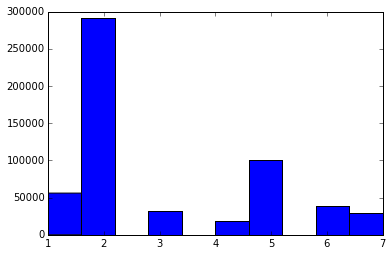

In [16]:
rf = RandomForestClassifier(n_estimators=25,max_depth=10)
print_out_kaggle_submission(rf,X,Y,test_data,test_ids)

###Scaling Real Valued Features - Removing Low Variance Binary Features###

In [7]:
#variables to scale
real_valued = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
       'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points','Total Distance to Hydrology']

X_real = df_train[real_valued].as_matrix()
df_train_bin = df_train.drop(real_valued,1)
X_bin = df_train_bin.as_matrix()

#remove binary features that have more than 80% of the same value
var = VarianceThreshold(threshold=(.8 * (1 - .8))) 
X_bin = var.fit_transform(X_bin)

test_real = df_test[real_valued].as_matrix()
df_test_bin = df_test.drop(real_valued,1)
test_bin = csr_matrix(df_test_bin.as_matrix())

#transform test binary variables based on training data
test_bin = var.transform(test_bin)

#scale and transform the (dense) real-valued features of the training and test data
scaler = preprocessing.StandardScaler()
scaler.fit_transform(X_real)
scaler.transform(test_real)

X = np.hstack([X_real,X_bin])
test_data = hstack([test_real,test_bin])

#delete data frames and temporary data arrays
del df_train_bin
del df_test_bin
del X_real
del X_bin
del test_real
del test_bin

print "New training size: %s" % str(X.shape)
print type(X)
print "New test size: %s" % str(test_data.shape)
print type(test_data)

New training size: (15120, 23)
<type 'numpy.ndarray'>
New test size: (565892, 23)
<class 'scipy.sparse.coo.coo_matrix'>


In [9]:
shuffle = np.random.permutation(np.arange(X.shape[0]))
X,Y = X[shuffle],Y[shuffle]

In [ ]:
rf = RandomForestClassifier(n_estimators=25,max_depth=10)
print_out_kaggle_submission(rf,X,Y,test_data,test_ids)

###Feature Selection###

In [ ]:
# Set some variables to hold dev and training data;
N = X.shape[0]
#test_data, test_labels = X[2*N/3:], Y[2*N/3:]
dev_data, dev_labels = X[2*N/3:], Y[2*N/3:]
train_data, train_labels = X[:2*N/3], Y[:2*N/3]

features = df_train.columns
rf = RandomForestClassifier(n_estimators=25,max_depth=5)
rf.fit(train_data,train_labels)

importances = zip(features,rf.feature_importances_)
importances.sort(key = lambda t: -1*t[1])
print "Feature ranks:\n"
for feat,i in importances[:15]:
    print '%s: %s\n' % (feat,i)

In [6]:
del train_data
del train_labels
del test_data

#top 10 features
df_train = df_train[[feature for feature,rank in importances[:10]]]
df_test = df_test[[feature for feature,rank in importances[:10]]]

X_reduced = df_train.as_matrix()
Y = df_train_labels.as_matrix()
test_reduced = df_test.as_matrix()

#shuffle the data again
shuffle = np.random.permutation(np.arange(X.shape[0]))
X,Y = X[shuffle],Y[shuffle]

print X_reduced.shape
print test_reduced.shape

(15120, 10)
(565892, 10)


In [ ]:
def TopTenBaseline(X,Y,test_data,test_ids):
    # Instantiate the KNeighborsClassifier class with appropriate k for entire data set
    clf = RandomForestClassifier(n_estimators=25,max_depth=10)
    clf.fit(X,Y)
    predicted = clf.predict(test_data)
    outfile = zip(test_ids, predicted)
    np.savetxt("KMSSubmission.csv", outfile, fmt='%i', delimiter=',', newline='\n', header='Id,Cover_Type',comments='')
    print "Saved ", len(outfile),"records to BaseSubmission.csv"


TopTenBaseline(X_reduced,Y,test_reduced,test_ids)

###Polynomial Features###



In [12]:
poly = preprocessing.PolynomialFeatures(degree=2,include_bias=False)
X_poly = poly.fit_transform(X)
#test_poly = poly.transform(test_data)

rf = RandomForestClassifier(n_estimators=25,max_depth=10)
rf.fit(X_poly,Y)
print 'Average accuracy: %s' % (np.mean(cross_val_score(rf,X_poly,Y,cv=5))*100)

Average accuracy: 71.0582010582


In [ ]:
def PolyTreeBaseline(X,Y,test_data,test_ids):
    # Instantiate the KNeighborsClassifier class with appropriate k for entire data set
    clf = RandomForestClassifier(n_estimators=25,max_depth=10)
    clf.fit(X,Y)
    predicted = clf.predict(test_data)
    outfile = zip(test_ids, predicted)
    np.savetxt("PolySubmission.csv", outfile, fmt='%i', delimiter=',', newline='\n', header='Id,Cover_Type',comments='')
    print "Saved ", len(outfile),"records to BaseSubmission.csv"

PolyTreeBaseline(X_poly,Y,test_poly,test_ids)

###Sparse Matrices and Scaling###
For our feature engineering we will convert the test dataframe to a SciPy sparse matrix. In particular we will use a Compressed Sparse Row matrix. Read more about Compressed Sparse Row matrices and their operations here: http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix

In [4]:
scaler = preprocessing.StandardScaler(copy=False,with_mean=False) #select 5 best features
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_data)

clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_scaled,Y)
print cross_val_score(clf,X_scaled,Y,cv=5)


[ 0.7172619   0.73776455  0.75661376  0.78835979  0.83862434]


C:\Python27\lib\site-packages\sklearn\utils\validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


####Scale the data, convert to Numpy arrays####

###Logistic Regression###

Let's look instead back at our Logistic Regression model. For this model we will map the error rate versus the total size of the training set for various sizes of the training and development sets.

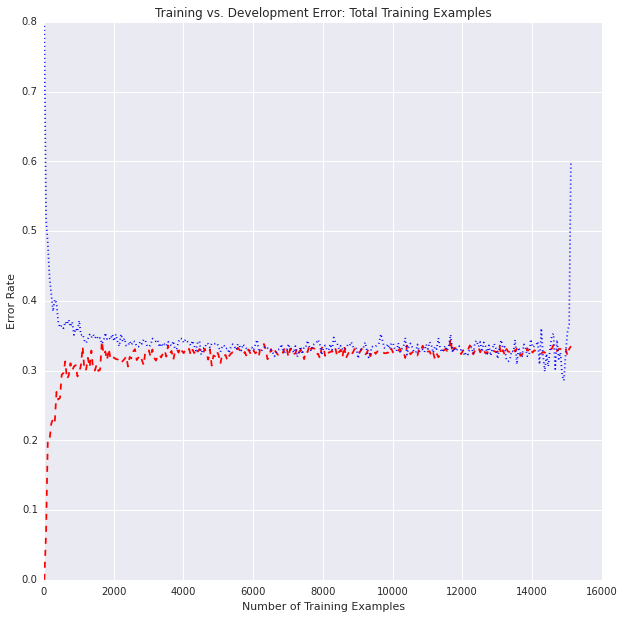

In [14]:
#Learning curves
train_acc = []
dev_acc = []
# Set some variables to hold dev and training data;
N = X.shape[0]
for i in range(10,N,50):
    X, Y = shuffle(X,Y,random_state=0) #shuffle the feature matrix and target array
    train_data, train_labels = X[:i], Y[:i]
    dev_data, dev_labels = X[i:],Y[i:]
    
    #iterate through several sizes of the feature set, 
    #and plot the error rate of the training prediction vs. 
    #the development prediction.
    lr = LogisticRegression(C=1)
    lr.fit(train_data,train_labels)
    
    train_acc.append(error_rate(lr,train_data,train_labels))
    dev_acc.append(error_rate(lr,dev_data,dev_labels))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(range(10,N,50),train_acc,'--',c='r')
ax.plot(range(10,N,50),dev_acc,':',c='b')
ax.set_ylabel("Error Rate")
ax.set_xlabel("Number of Training Examples")
ax.set_title("Training vs. Development Error: Total Training Examples")



The chart shows that although our raw Logistic Regression model has a high amount of bias, the variance is very low. With a high bias model our data as it stands now simply does not fit the data very well, and adding more data points will not change the error rate. Instead we want to explore adding new higher-order features through feature engineering to see if we can fit the data better.

###Feature Engineering###
Now that we have a biased model we will work on improving the feature space. In particular, let's add polynomial features to our data. By adding interaction terms we can try to capture a non-linear decision boundary with our Logistic Regression function.

We will use sci-kit learn's cross validation library to run a 5-fold cross validation on our fit model. You can read more about cross validation here: http://scikit-learn.org/stable/modules/cross_validation.html

In [4]:
lr = LogisticRegression(C = .1)
lr.fit(X,Y)
print cross_val_score(lr,X,Y,cv=5)

[ 0.59193122  0.64285714  0.65112434  0.65641534  0.73313492]


We can see that by adding polynomial features we see an average increase in accuracy by approximately 5% over the baseline logistic regression model.

Another option to reduce bias in a model is to tweak the regularization parameter, C. Let's run our previous error comparison for various values of C.

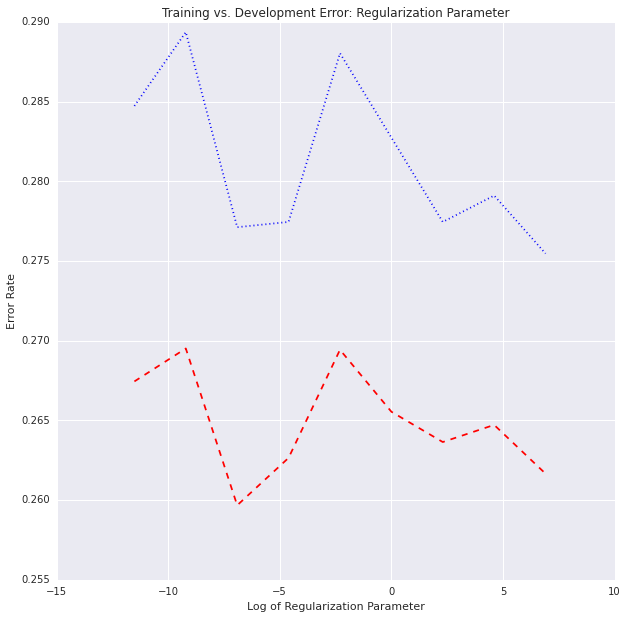

In [4]:
poly = preprocessing.PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

train_acc = []
dev_acc = []
# Set some variables to hold dev and training data;
N = X_poly.shape[0]
X_poly, Y = shuffle(X_poly,Y,random_state=0) #shuffle the feature matrix and target array
train_data, train_labels = X_poly[:N*8/10], Y[:N*8/10]
dev_data, dev_labels = X_poly[N*8/10:],Y[N*8/10:]
for i in [10**i for i in range(-5,4)]:
    #iterate through several sizes for the regularization parameter, 
    #and plot the error rate of the training prediction vs. 
    #the development prediction.
    lr = LogisticRegression(C=i)
    lr.fit(train_data,train_labels)
    
    train_acc.append(error_rate(lr,train_data,train_labels))
    dev_acc.append(error_rate(lr,dev_data,dev_labels))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(np.log([10**i for i in range(-5,4)]),train_acc,'--',c='r')
ax.plot(np.log([10**i for i in range(-5,4)]),dev_acc,':',c='b')
ax.set_ylabel("Error Rate")
ax.set_xlabel("Log of Regularization Parameter")
ax.set_title("Training vs. Development Error: Regularization Parameter")

